# Classification using Random Forest

In this notebook we'll be working through a data set containing information from the US Census Bureau, and available at https://code.datasciencedojo.com/datasciencedojo/datasets/tree/master/Census%20Income. We will be building a model to predict if an individual's annual income is greater or less than $50,000.00 from 15 features provided.

Let's start with importing packages and loading the data.

## Import Packages

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set_style('ticks')

## Load Data

In [2]:
raw = pd.read_csv('adult.data.csv')
raw.head()

,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
0,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
1,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
2,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
3,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K
4,37,Private,284582,Masters,14,Married-civ-spouse,Exec-managerial,Wife,White,Female,0,0,40,United-States,<=50K


Column names are not provided. We'll have to insert them.

In [3]:
nrow = raw.columns.values

In [4]:
new_cols = ['age','workclass','final_wgt', 'ed', 'ed_years', 'm_status', 'occ', 'relat', 'race',
           'sex', 'cptl_gain', 'cptl_loss', 'work_hr', 'native', 'income']

raw = pd.DataFrame(np.concatenate((nrow.reshape(1,15), raw.values), axis=0), columns=new_cols)
df = raw.copy()
df.head()

,age,workclass,final_wgt,ed,ed_years,m_status,occ,relat,race,sex,cptl_gain,cptl_loss,work_hr,native,income
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32561 entries, 0 to 32560
Data columns (total 15 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        32561 non-null  object
 1   workclass  32561 non-null  object
 2   final_wgt  32561 non-null  object
 3   ed         32561 non-null  object
 4   ed_years   32561 non-null  object
 5   m_status   32561 non-null  object
 6   occ        32561 non-null  object
 7   relat      32561 non-null  object
 8   race       32561 non-null  object
 9   sex        32561 non-null  object
 10  cptl_gain  32561 non-null  object
 11  cptl_loss  32561 non-null  object
 12  work_hr    32561 non-null  object
 13  native     32561 non-null  object
 14  income     32561 non-null  object
dtypes: object(15)
memory usage: 3.7+ MB


We'll change the type of our quantitave variables to integers. 

In [6]:
quant = ['age', 'final_wgt', 'ed_years', 'cptl_gain', 'cptl_loss', 'work_hr']
df[quant] = df[quant].astype('int') 

In [7]:
qual = list(df.drop(quant+['income'], axis=1).columns.values)

The values of our qualitative variables have spaces, so let's strip them.

In [8]:
df[qual] = df[qual].apply(lambda x: x.str.lstrip())

In [9]:
from sklearn.preprocessing import LabelEncoder

Renaming our target variable and encoding it.

- Income <= 50K as 0
- Income >= 50K as 1

In [10]:
enc = LabelEncoder()
enc.fit(df.income)
target = enc.transform(df.income)
df['income'] = target
df.rename(columns={'income': 'target'}, inplace=True)

greater = df.target.sum()/df.shape[0]
less = 1 - greater 
print('Target Distribution:')
print(f'0: {less*100:.3}%  |  1: {greater*100:.3}%')

Target Distribution:
0: 75.9%  |  1: 24.1%


We can see that about that the majority has an annual income less than 50K. 

We'll continue with some feature engineering.

# Feature Engineering

Most of our qualitative feautures have several possible values, we'll analize those categories and merge into a single category those that have a similar proportion of individuals with <target=1>, and due to their characterisitcs could belong together (we'll prioritize similar proportions).

We'll then plot the resulting values using our plot function.

In [11]:
def count_plot(df, y_str):
    plt.figure(figsize=(10,6))
    sns.countplot(data=df, y=y_str, hue='target')
    plt.title(y_str.upper(), size=14);

### Workclass

In [12]:
df['workclass'].unique()

array(['State-gov', 'Self-emp-not-inc', 'Private', 'Federal-gov',
       'Local-gov', '?', 'Self-emp-inc', 'Without-pay', 'Never-worked'],
      dtype=object)

In [13]:
no_value = df[df['workclass']=='?']
no_value.head(3)

,age,workclass,final_wgt,ed,ed_years,m_status,occ,relat,race,sex,cptl_gain,cptl_loss,work_hr,native,target
27,54,?,180211,Some-college,10,Married-civ-spouse,?,Husband,Asian-Pac-Islander,Male,0,0,60,South,1
61,32,?,293936,7th-8th,4,Married-spouse-absent,?,Not-in-family,White,Male,0,0,40,?,0
69,25,?,200681,Some-college,10,Never-married,?,Own-child,White,Male,0,0,40,United-States,0


There are some null entries as **"?"**. We don't know what possible category the individual belongs to; and since the categories are significant for our analysis, we'll drop the entire row. 

In [14]:
df = df.drop(no_value.index.values, axis=0)
df['workclass'].unique()

array(['State-gov', 'Self-emp-not-inc', 'Private', 'Federal-gov',
       'Local-gov', 'Self-emp-inc', 'Without-pay', 'Never-worked'],
      dtype=object)

In [15]:
workclass = df.groupby('workclass')
workclass['target'].agg('mean').sort_values()

workclass
Never-worked        0.000000
Without-pay         0.000000
Private             0.218673
State-gov           0.271957
Self-emp-not-inc    0.284927
Local-gov           0.294792
Federal-gov         0.386458
Self-emp-inc        0.557348
Name: target, dtype: float64

We'll merge **<'Never-worked','Without-pay'>** and **<'Local-gov','State-gov'>**.

In [16]:
df['workclass'] = df['workclass'].apply(lambda x: x.replace(x, 'Gov_nofed') if x in ['Local-gov','State-gov'] else x)
df['workclass'] = df['workclass'].apply(lambda x: x.replace(x, 'No_job') if x in ['Never-worked','Without-pay'] else x)
df['workclass'].unique() 

array(['Gov_nofed', 'Self-emp-not-inc', 'Private', 'Federal-gov',
       'Self-emp-inc', 'No_job'], dtype=object)

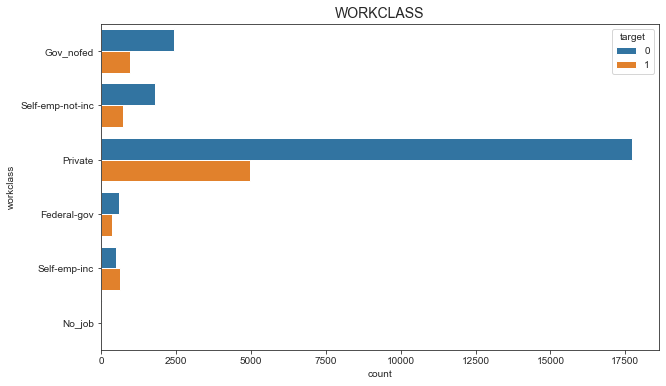

In [17]:
count_plot(df, 'workclass')

### Education

In [18]:
ed = df.groupby('ed')
ed['target'].agg('mean').sort_values()

ed
Preschool       0.000000
1st-4th         0.038462
5th-6th         0.046205
9th             0.056156
11th            0.056764
7th-8th         0.066202
10th            0.072029
12th            0.078880
HS-grad         0.163407
Some-college    0.199498
Assoc-acdm      0.253922
Assoc-voc       0.263437
Bachelors       0.419915
Masters         0.561791
Doctorate       0.741206
Prof-school     0.743728
Name: target, dtype: float64

We'll merge **<from Preschool to 12th>**, **<'Assoc-voc','Assoc-acdm'>** and **<'Doctorate','Prof-school'>**.

In [19]:
HSnon = df[df['ed_years']<9]['ed'].unique()
HSnon

array(['11th', '9th', '7th-8th', '5th-6th', '10th', 'Preschool', '12th',
       '1st-4th'], dtype=object)

In [20]:
df['ed'] = df['ed'].apply(lambda x: x.replace(x, 'HS_none') if x in HSnon else x)
df['ed'] = df['ed'].apply(lambda x: x.replace(x, 'Assoc') if x in ['Assoc-voc','Assoc-acdm'] else x)
df['ed'] = df['ed'].apply(lambda x: x.replace(x, 'Prof_Phd') if x in ['Doctorate','Prof-school'] else x)
df['ed'].unique()

array(['Bachelors', 'HS-grad', 'HS_none', 'Masters', 'Some-college',
       'Assoc', 'Prof_Phd'], dtype=object)

In [21]:
ed = df.groupby('ed')
ed['target'].agg('mean').sort_values()

ed
HS_none         0.061438
HS-grad         0.163407
Some-college    0.199498
Assoc           0.259291
Bachelors       0.419915
Masters         0.561791
Prof_Phd        0.742678
Name: target, dtype: float64

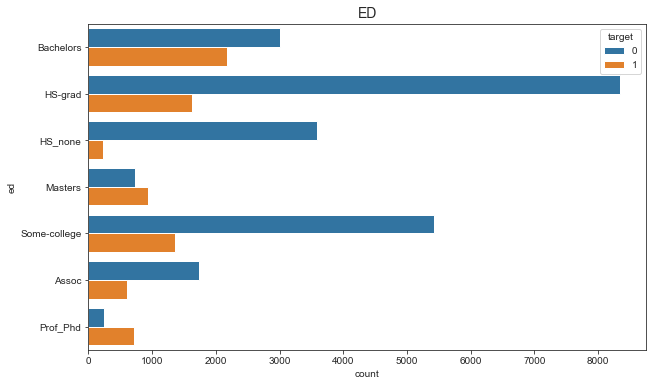

In [22]:
count_plot(df, 'ed')

### Marital Status

In [23]:
marital = df.groupby('m_status')
marital['target'].agg('mean')

m_status
Divorced                 0.107302
Married-AF-spouse        0.476190
Married-civ-spouse       0.454742
Married-spouse-absent    0.084833
Never-married            0.048603
Separated                0.068822
Widowed                  0.096429
Name: target, dtype: float64

We'll merget **<'Married-AF-spouse', 'Married-civ-spouse'>** and **<'Divorced', 'Married-spouse-absent', 'Separated', 'Widowed'>**.

In [24]:
mar = ['Married-AF-spouse', 'Married-civ-spouse']
mar_no = ['Divorced', 'Married-spouse-absent', 'Separated', 'Widowed']
df['m_status'] = df['m_status'].apply(lambda x: x.replace(x, 'Married') if x in mar else x)
df['m_status'] = df['m_status'].apply(lambda x: x.replace(x, 'Married_bef') if x in mar_no else x)
df['m_status'].unique()

array(['Never-married', 'Married', 'Married_bef'], dtype=object)

In [25]:
marital = df.groupby('m_status')
marital['target'].agg('mean')

m_status
Married          0.454773
Married_bef      0.098806
Never-married    0.048603
Name: target, dtype: float64

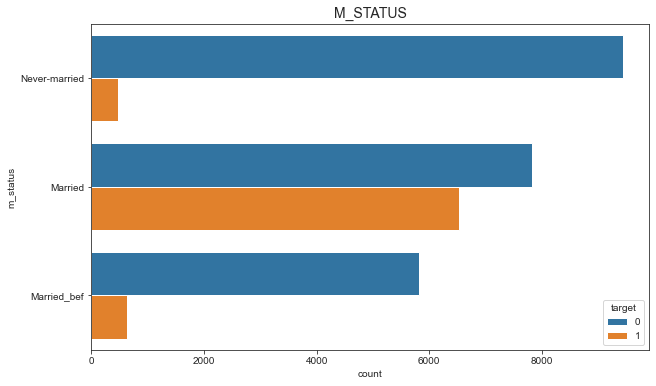

In [26]:
count_plot(df, 'm_status')

### Occupation

In [27]:
df.occ.unique()

array(['Adm-clerical', 'Exec-managerial', 'Handlers-cleaners',
       'Prof-specialty', 'Other-service', 'Sales', 'Craft-repair',
       'Transport-moving', 'Farming-fishing', 'Machine-op-inspct',
       'Tech-support', 'Protective-serv', 'Armed-Forces',
       'Priv-house-serv', '?'], dtype=object)

Dropping **"?"** entries.

In [28]:
no_value_occ = df[df['occ']=='?']
df = df.drop(no_value_occ.index.values, axis=0)
df['occ'].unique()

array(['Adm-clerical', 'Exec-managerial', 'Handlers-cleaners',
       'Prof-specialty', 'Other-service', 'Sales', 'Craft-repair',
       'Transport-moving', 'Farming-fishing', 'Machine-op-inspct',
       'Tech-support', 'Protective-serv', 'Armed-Forces',
       'Priv-house-serv'], dtype=object)

In [29]:
occ = df.groupby('occ')
occ['target'].agg('mean').sort_values()

occ
Priv-house-serv      0.006711
Other-service        0.041578
Handlers-cleaners    0.062774
Armed-Forces         0.111111
Farming-fishing      0.115694
Machine-op-inspct    0.124875
Adm-clerical         0.134483
Transport-moving     0.200376
Craft-repair         0.226641
Sales                0.269315
Tech-support         0.304957
Protective-serv      0.325116
Prof-specialty       0.449034
Exec-managerial      0.484014
Name: target, dtype: float64

We have many different kinds of occupations and not a natural way to group them. To avoid having so many categories we'll prioritize their proportions of <target=1> and merge them into five groups **<'low','lowh','mid','lhigh','high'>**.

In [30]:
occ_low = ['Priv-house-serv', 'Other-service', 'Handlers-cleaners']
occ_lowh = ['Armed-Forces', 'Farming-fishing', 'Machine-op-inspct', 'Adm-clerical'] 
occ_mid = ['Transport-moving', 'Craft-repair', 'Sales']
occ_highl = ['Tech-support', 'Protective-serv']
occ_high = ['Prof-specialty', 'Exec-managerial']
df['occ'] = df['occ'].apply(lambda x: x.replace(x, 'low') if x in occ_low else x)
df['occ'] = df['occ'].apply(lambda x: x.replace(x, 'lowh') if x in occ_lowh else x)
df['occ'] = df['occ'].apply(lambda x: x.replace(x, 'mid') if x in occ_mid else x)
df['occ'] = df['occ'].apply(lambda x: x.replace(x, 'highl') if x in occ_highl else x)
df['occ'] = df['occ'].apply(lambda x: x.replace(x, 'high') if x in occ_high else x)
df['occ'].unique()

array(['lowh', 'high', 'low', 'mid', 'highl'], dtype=object)

In [31]:
occ = df.groupby('occ')
occ['target'].agg('mean').sort_values()

occ
low      0.046531
lowh     0.128856
mid      0.238819
highl    0.313253
high     0.466366
Name: target, dtype: float64

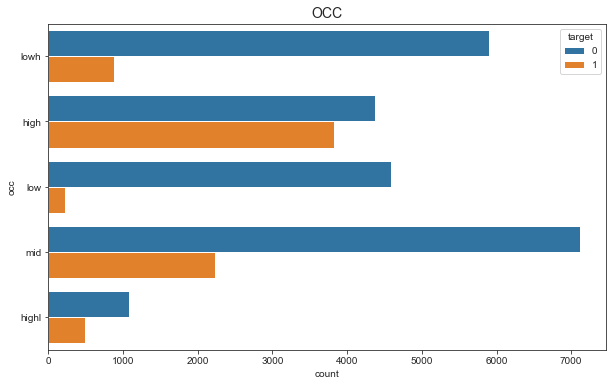

In [32]:
count_plot(df, 'occ')

### Relationship

In [33]:
relat = df.groupby('relat')
relat['target'].agg('mean').sort_values()

relat
Own-child         0.014586
Other-relative    0.039216
Unmarried         0.066035
Not-in-family     0.106548
Husband           0.455683
Wife              0.491289
Name: target, dtype: float64

We'll merge **<'Husband','Wife'>**.

In [34]:
df['relat'] = df['relat'].apply(lambda x: x.replace(x, 'Husb_Wife') if x in ['Husband','Wife'] else x)
df['relat'].unique()

array(['Not-in-family', 'Husb_Wife', 'Own-child', 'Unmarried',
       'Other-relative'], dtype=object)

In [35]:
relat = df.groupby('relat')
relat['target'].agg('mean').sort_values()

relat
Own-child         0.014586
Other-relative    0.039216
Unmarried         0.066035
Not-in-family     0.106548
Husb_Wife         0.459297
Name: target, dtype: float64

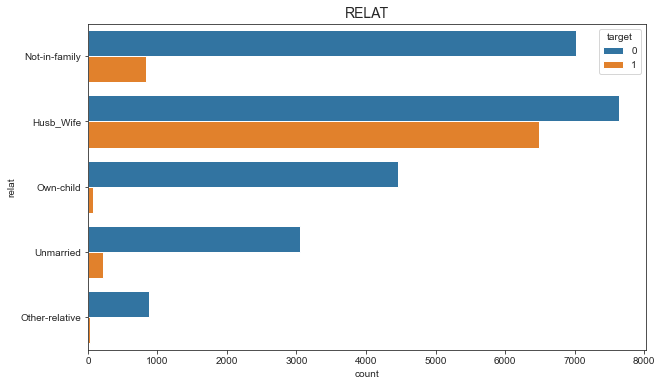

In [36]:
count_plot(df, 'relat')

### Race

In [37]:
race = df.groupby('race')
race['target'].agg('mean').sort_values()

race
Other                 0.092742
Amer-Indian-Eskimo    0.118881
Black                 0.129942
White                 0.264020
Asian-Pac-Islander    0.278234
Name: target, dtype: float64

We'll merge **<'Asian-Pac-Islander','White'>** since they have almost identical proportions.

In [38]:
#df['race'] = df['race'].apply(lambda x: x.replace(x, 'White_Asian') if x in ['Asian-Pac-Islander','White'] else x)
#df['race'].unique()

In [39]:
race = df.groupby('race')
race['target'].agg('mean').sort_values()

race
Other                 0.092742
Amer-Indian-Eskimo    0.118881
Black                 0.129942
White                 0.264020
Asian-Pac-Islander    0.278234
Name: target, dtype: float64

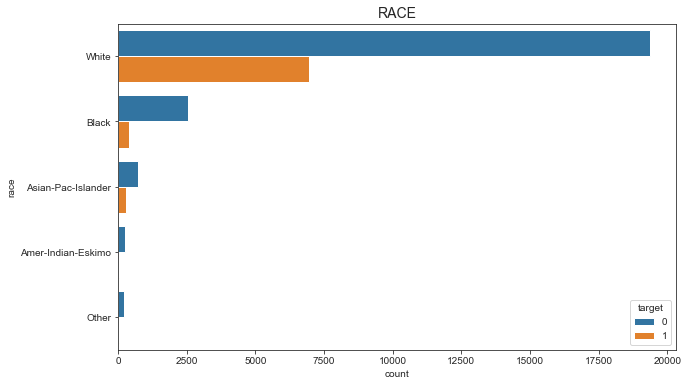

In [40]:
count_plot(df, 'race')

### Sex

In [41]:
sex = df.groupby('sex')
sex['target'].agg('mean').sort_values()

sex
Female    0.113494
Male      0.313787
Name: target, dtype: float64

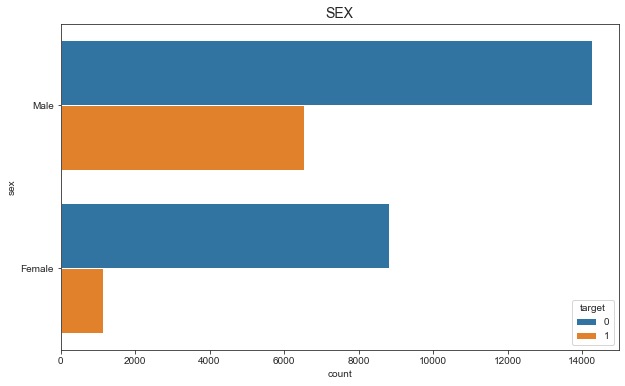

In [42]:
count_plot(df, 'sex')

### Native

In [43]:
df.native.unique()

array(['United-States', 'Cuba', 'Jamaica', 'India', '?', 'Mexico',
       'Puerto-Rico', 'Honduras', 'England', 'Canada', 'Germany', 'Iran',
       'Philippines', 'Poland', 'Columbia', 'Cambodia', 'Thailand',
       'Ecuador', 'Laos', 'Taiwan', 'Haiti', 'Portugal',
       'Dominican-Republic', 'El-Salvador', 'France', 'Guatemala',
       'Italy', 'China', 'South', 'Japan', 'Yugoslavia', 'Peru',
       'Outlying-US(Guam-USVI-etc)', 'Scotland', 'Trinadad&Tobago',
       'Greece', 'Nicaragua', 'Vietnam', 'Hong', 'Ireland', 'Hungary',
       'Holand-Netherlands'], dtype=object)

Dropping **"?"** entries.

In [44]:
native_none = df[df['native'] == '?']
df.drop(native_none.index.values, axis=0, inplace=True)

In [45]:
native = df.groupby('native')
prob = native[['target']].agg('mean').sort_values('target', ascending=False)
prob

,target
native,
Taiwan,0.452381
France,0.444444
Iran,0.428571
India,0.400000
Japan,0.389831
Cambodia,0.388889
Yugoslavia,0.375000
Italy,0.352941
England,0.348837


While we can see that most of the Latin-American countries have low proportion of <target=1>, grouping by regions doesn't seem  to fit in general. Again to reduce our categories we'll prioritize the proportions of <target=1> and merge the coutnries into five groups **<'low','lowh','mid','midh','high'>**.  

In [46]:
native_low = prob[prob['target']<.10].index.values
native_lowh = prob[(prob['target']>=.10) & (prob['target']<.20)].index.values
native_mid = prob[(prob['target']>=.20) & (prob['target']<.30)].index.values
native_midh = prob[(prob['target']>=.30) & (prob['target']<.40)].index.values
native_high = prob[prob['target']>=.40].index.values

df['native'] = df['native'].apply(lambda x: x.replace(x, 'low') if x in native_low else x)
df['native'] = df['native'].apply(lambda x: x.replace(x, 'lowh') if x in native_lowh else x)
df['native'] = df['native'].apply(lambda x: x.replace(x, 'mid') if x in native_mid else x)
df['native'] = df['native'].apply(lambda x: x.replace(x, 'midh') if x in native_midh else x)
df['native'] = df['native'].apply(lambda x: x.replace(x, 'high') if x in native_high else x)
df.native.unique()


array(['mid', 'lowh', 'high', 'low', 'midh'], dtype=object)

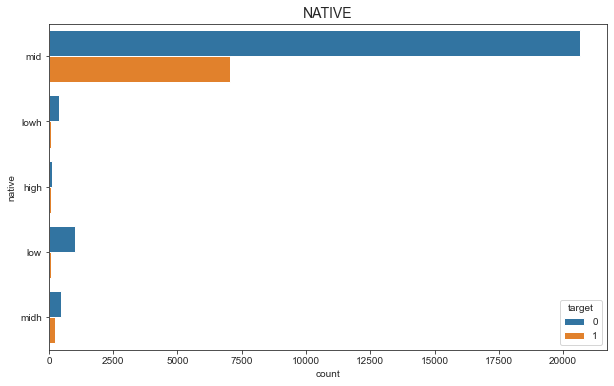

In [47]:
count_plot(df, 'native')

# Quantitative Variables

For our quantitative variables let's compare those entries with <target=0> with those that have <target=1>, and see if we can visually identify some clusters.

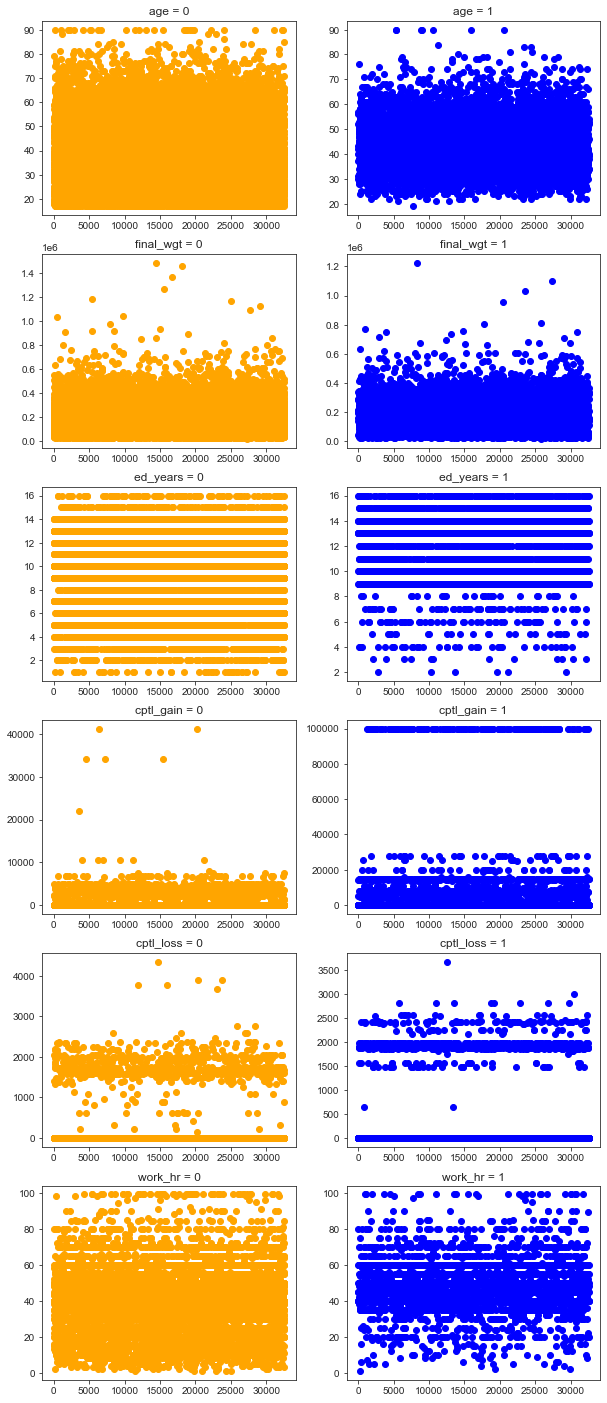

In [48]:
fig, ax = plt.subplots(6,2, figsize=(10,25))
quant_df = df[quant+['target']]
for i in range(12):
    
    if i < 6:
        ax[i,0].plot(quant_df[quant_df['target']==0][quant[i]], 'o', color='orange')
        ax[i,0].set_title(quant[i]+' = 0')
    else:
        ax[i-6,1].plot(quant_df[quant_df['target']==1][quant[i-6]], 'o', color='blue')
        ax[i-6,1].set_title(quant[i-6]+' = 1')

- **cptl_gain** - We can see a cluster of individuals with an entry starting at around 20,000 all the way to 100,000 with <target=1>. 
- **cptl_loss** - There is a cluster of individuals with an entry of around 2500 and above with <target=1>.
- **age** - We can observe that <targe=1> has a disctint majority of entries at 70 and above.  

We'll proceed to create our dummy variables and perform a fit a Random Forest Classifier model to our data.

## Dummy Variables

In [49]:
df_tree = pd.get_dummies(df)
X = df_tree.drop('target', axis=1)
y = df_tree['target']

## Random Forest

In [50]:
from sklearn.ensemble import RandomForestClassifier

Our function will fit a Random Forest for each possible combination given of **n_estimators, min_impurity and min_samples_leaf**, and returns a dataframe with the **train error and out-of-bag error**. 

Note: Depending on the number of inputs it can take some time to complete.

In [51]:
def randomForest(X, y, n_estimators, min_impurity, min_samples_leaf):
    rf = RandomForestClassifier(random_state=2709)
    rf.set_params(n_estimators=n_estimators, min_impurity_decrease=min_impurity, min_samples_leaf=min_samples_leaf,
                  max_features='sqrt', oob_score=True)
    rf.fit(X,y)
    pred = rf.predict(X)
    error = sum(pred != y) / len(pred) 
    oob_error = 1 - rf.oob_score_
    oob_dec_func = rf.oob_decision_function_
    results = [error, oob_error]
    return results, oob_dec_func

def fit_rf(X, y, n_estimators, min_impurity, min_samples_leaf):
    res_list = []
    for i in range(len(n_estimators)):
        for j in range(len(min_impurity)):
            for k in range(len(min_samples_leaf)):
                res, _ = randomForest(X, y, n_estimators[i], min_impurity[j], min_samples_leaf[k])
                params = [n_estimators[i], min_impurity[j], min_samples_leaf[k]]
                res_list.append(params + res)
    
    res_df = pd.DataFrame(res_list, columns=['n_estimators', 'min_impurity', 'min_samples_leaf',
                                       'train_error', 'oob_error'])
    return res_df

In [52]:
X = df_tree.drop('target', axis=1)
y = df_tree.target

In [53]:
results_df = fit_rf(X, y, [1000], [0.000005,0.00001,0.00005,0.0001], [.01,2])
results_df.sort_values('oob_error')

,n_estimators,min_impurity,min_samples_leaf,train_error,oob_error
1,1000,0.000005,2.00,0.104337,0.137524
3,1000,0.000010,2.00,0.110934,0.138220
5,1000,0.000050,2.00,0.131026,0.141469
7,1000,0.000100,2.00,0.140077,0.144884
0,1000,0.000005,0.01,0.161296,0.161594
2,1000,0.000010,0.01,0.161461,0.161727
4,1000,0.000050,0.01,0.161892,0.162622
6,1000,0.000100,0.01,0.162522,0.162788


We'll select the parameters that returned the lowest out-of-bag error and fit a Random Forest.

In [54]:
rf = RandomForestClassifier(n_estimators=1000, min_impurity_decrease=.000005, min_samples_leaf=2,
                            max_features='sqrt', oob_score=True, random_state=2709)
rf.fit(X, y)


RandomForestClassifier(max_features='sqrt', min_impurity_decrease=5e-06,
                       min_samples_leaf=2, n_estimators=1000, oob_score=True,
                       random_state=2709)

Let's use our model to predict our current data set.

In [55]:
pred = rf.predict(X)
error = sum(pred != y) / len(pred) 
oob_error = 1 - rf.oob_score_
print('Error: ',error, '\nOut-of-bag Error:', oob_error)

Error:  0.10433658245474438 
Out-of-bag Error: 0.13752403686758174


The Out-of-bag Error give us a good idea of how our model will perform with another data set.

Now let's check the important features.

In [56]:
pd.DataFrame(rf.feature_importances_, index=X.columns.values, 
             columns=['feat_import']).sort_values('feat_import', ascending=False)

,feat_import
cptl_gain,0.145434
relat_Husb_Wife,0.117871
m_status_Married,0.106367
ed_years,0.098252
age,0.086565
work_hr,0.054095
final_wgt,0.052873
occ_high,0.050126
m_status_Never-married,0.039814
cptl_loss,0.037059


The most important feature is **cptl_gain**, from which we noticed a cluster in our plots. We can also see some of the features we engineered in the most important such as: **relat_Husb_Wife** and **m_status_Married**